# DeepProjection Quickstart - How to train and predict

## Introduction

DeepProjection (DP) is an algorithm for trainable projection of 3D microscopy stacks. This notebook shows how to (1) create training data set, (2) train DP and (3) predict single stacks and movies with DP.

**Important:** For DP training, the usage of CUDA is inevitable. To enable training and prediction on GPUs, users need to install [CUDA toolkit](https://developer.nvidia.com/cuda-toolkit) and the corresponding version of PyTorch from the [official PyTorch website](https://pytorch.org/get-started/locally/). Select the correct version of CUDA on this webpage and run the command in your terminal. DeepProjection was tested with CUDA 11.0 and Pytorch 1.7.1.


## Training data

To train your own DP network, select a set of 20-100 stacks represantative for the data you want to later predict. Then mask each stack individually in the software [Fiji](https://fiji.sc/) using the freehand selection tool. Areas shown in yellow, at the example of Drosophila dorsal closure, with yolk granules, gut cells, blurry cell boundaries and dark background around the tissue, are cut out. Training data for Drosophila dorsal closure and zebrafish periderm can be found [here](https://e.pcloud.link/publink/show?code=kZ81BJZAKSgyWiWhYka06JIhA3Cq7ow75y7).
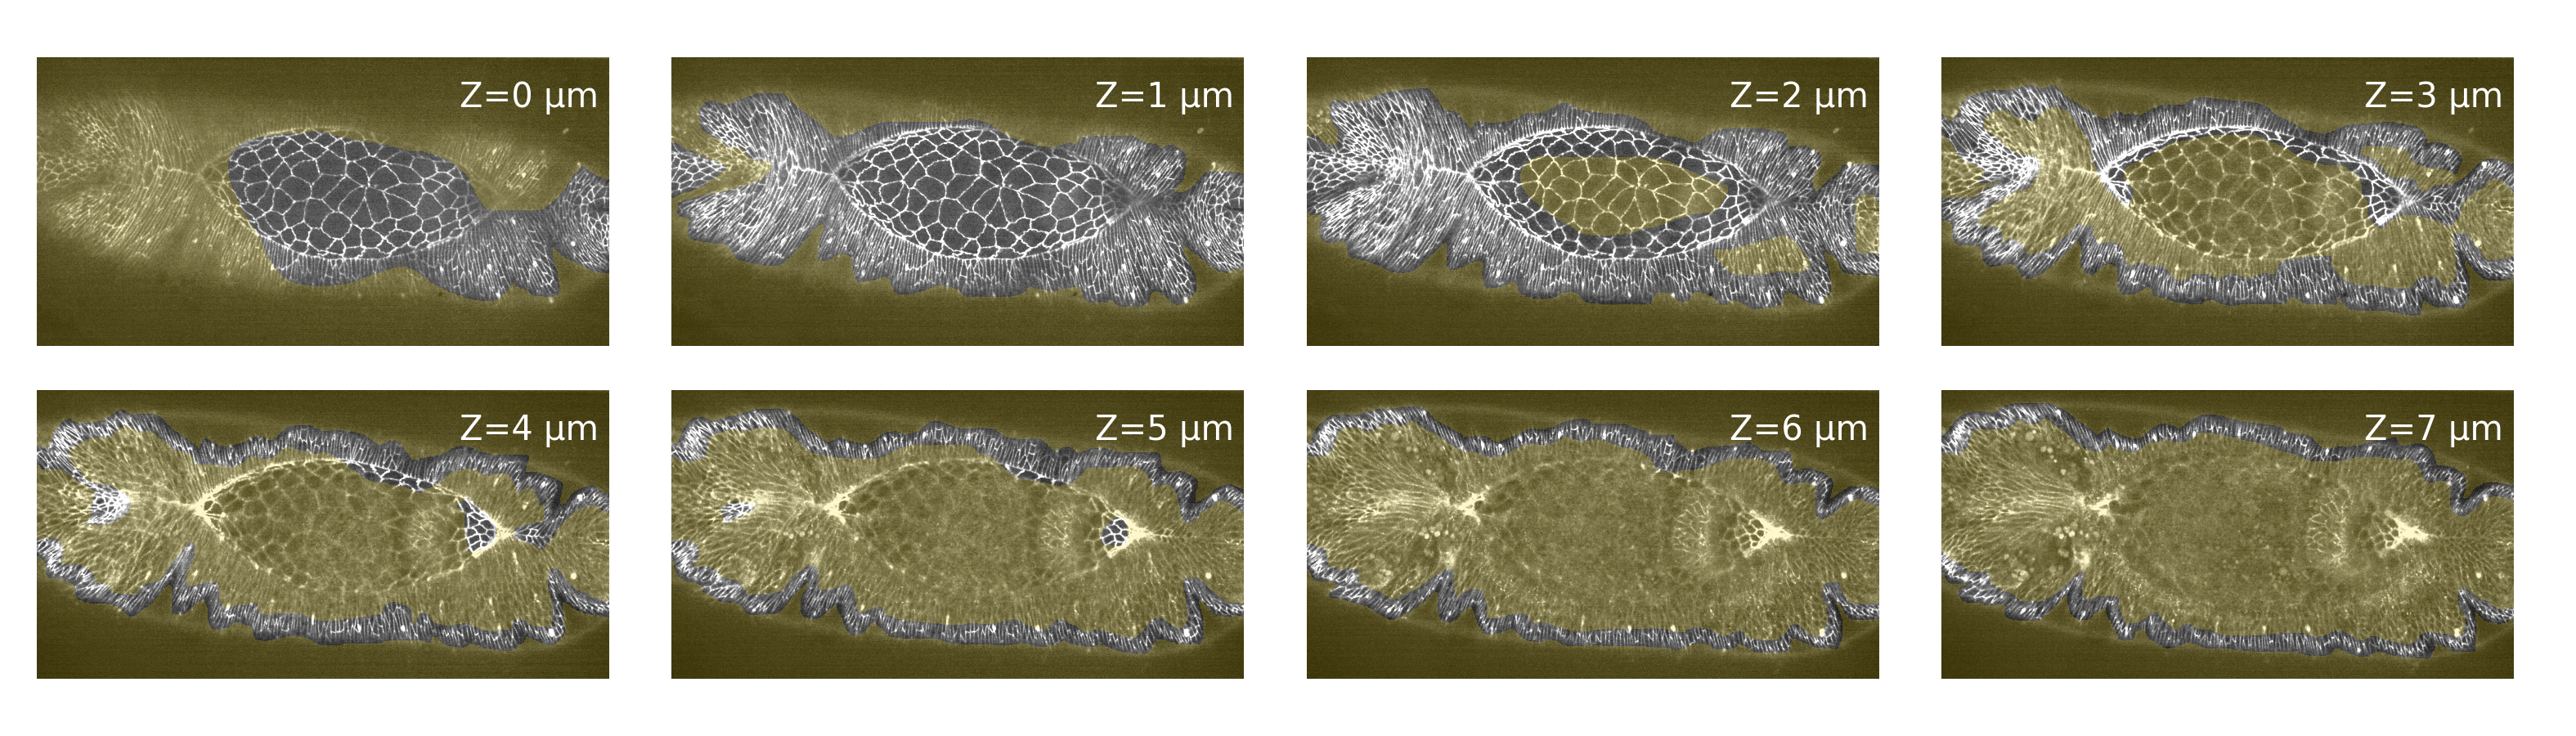


Training stacks and masked stacks need to have the following folder structure (stacks and masked stacks with exactly identical names in separate folders):

```
path/to/training/data/
|
├── image
│   ├── 1.tif
│   ├── 2.tif
│   ├── 3.tif
│   ├── 4.tif
│   ├── stack3.tif
│   ├── whatever_name42.tif
│   ├── 5.tif
│   ├── ...
│   ├── ...
└── mask
    ├── 1.tif
    ├── 2.tif
    ├── 3.tif
    ├── 4.tif
    ├── stack3.tif
    ├── whatever_name42.tif
    ├── 5.tif
    ├── ...
    ├── ...
```
The `DataProcess` class creates a PyTorch `Dataset` object. Paths of directories with training data and labels as well as parameters for data processing and data augmentation are all specified upon initialization function, see below.
```
Modifies and augments training data, and then a training data object for trainer

        Parameters
        ----------
        source_dirs : tuple(str, str)
            Training data directories [raw_stacks_dir, masked_stacks_dir]
        dim_out : tuple(int, int)
            Resize dimensions (has to be divisible by 8)
        n_slices : int
            # slices/stack (needs to be > maximal slice number in data set, stacks smaller are zero-padded)
        aug_factor : int
            Factor by which data is augmented
        noise_amp : float
            Amplitude of noise for augmentation
        brightness_contrast : tuple(float, float)
            Factors for augmentation of [brightness, contrast]
        random_flip_z : bool
            If True, the stacks are randomly flipped in z-direction
        padding_mode : str, default 'edge'
            Padding mode for z-padding ('edge', 'constant', 'mirror')
        clip_thrs : tuple(float, float)
            Clip thresholds for intensity normalization [lower, upper] in percentiles
        mode : str
            Training mode for loss calculation ('binary_mask' or 'max_projection')
        data_path : str
            Path for training data tree (modified data with augmentations etc)
        create : bool
            If False, training data set is not created, the existing set in data_path is used.
```

In [1]:
# import package
import deepprojection as dp

In [ ]:
# path to training data
dir_images = 'E:/path/to/images/'
dir_masks = 'E:/path/to/masks/'

# path to directory for training data generation (is created automatically, drive should have enough storage)
data_path = './data/' # './data/ is parent directory

# generation of training data set
data = dp.DataProcess([dir_images,dir_masks], create=True, aug_factor=10,
                   random_flip_z=False, clip_thrs=(0, 99.9), brightness_contrast=(0.2,0.2),
                   noise_amp=20, dim_out=(512, 512), n_slices=10, data_path=data_path)

## Training

For training of DP, you need to create a `Trainer` object to specify all training parameters:

```
Parameters

----------
        dataset
            Training data set (object of DataProcess class)
        num_epochs : int
            Number of training epochs
        network
            Neural network class
        mode : str = 'binary_mask'
            Training mode for loss calculation ('binary_mask' or 'max_projection')
        n_slices : int
            Number of z slices
        batch_size : int
            Batch size
        n_filter : int
            Number of convolutional filters
        lr : float
            Learning rate
        val_split : float
            Validation split
        save_dir : str
            Path to save network weights
        load_weights : str, optional
            If not None, load pretrained weights prior to training in path "load_weights"
        save_iterations : bool
            If True, weight of each epoch are save in save_dir
        weights_edge_loss : tuple(float, float) = (1, 0)
            Ratio between edge loss and area loss (not clear if useful)
        loss_func : str
            Loss function ('BCEDiceLoss', 'TverskyLoss', 'logcoshTverskyLoss')
        loss_params : tuple(float, float)
            Loss parameters, depending on loss function (for logcoshTverskyLoss/TverskyLoss = alpha, beta)
```

In [ ]:
# directory for saving trained networks
save_dir = 'path/for/trained/networks/'

# create trainer to initialize model and training parameters
training = dp.Trainer(data, network=dp.ProjNet, num_epochs=200, n_slices=10, batch_size=1, 
                   load_weights=None, lr=0.0005, n_filter=8, mode='binary_mask', 
                   save_iterations=True, save_dir=save_dir, weights_edge_loss=(1, 0),
                   loss_func='logcoshTverskyLoss', loss_params=(0.3, 0.7))


In [ ]:
# start training (can take ~ 10 hours)
training.start()

## Prediction
Test data for prediction and pretrained networks can be found [here](https://e.pcloud.link/publink/show?code=kZ81BJZAKSgyWiWhYka06JIhA3Cq7ow75y7).

There are two Prediction classes: `PredictStack` for single stacks and `PredictMovie`for movies. Prediction is started upon initialization. The initialization methods have following parameters: 

### Single stacks
```
Parameters
        ----------
        filename : str
            Filename of stack
        filename_output : str
            Filename of output
        model
            Network model
        weights : str
            Trained model weights
        resize_dim : tuple(int, int)
            Resize dimensions (has to be divisible by 8)
        clip_thrs : float
            Higher percentile for intensity clipping
        n_filter : int
            Number of convolutional filters
        mask_thrs : float = None
            If not None, additional binary thresholding of predicted masks
        export_masks : bool
            If True, the predicted masks are stored
        invert_slices : book
            If True, z order of stacks is inverted prior to prediction
```


In [ ]:
# predict single stack
filename = "path/of/input/stack.tif"
filename_output = "path/of/output.tif"
path_weights = "path/of/trained/weights.p"

predict = dp.PredictStack(filename, filename_output, model=dp.ProjNet, weights=path_weights, 
                          n_filter=8, resize_dim=(512, 512))

### Movies
Predicted movies are saved in parent directory.

```
PredictMovie

Parameters
        ----------
        folder : str
            Folder containing stacks (filesnames need to have time at end)
        model
            Network model
        weights : str
            Trained model weights
        resize_dim : tuple(int, int)
            Resize dimensions (has to be divisible by 8)
        clip_thrs : float
            Higher percentile for intensity clipping
        n_filter : int
            Number of convolutional filters
        mask_thrs : float = None
            If not None, additional binary thresholding of predicted masks
        folder_color : str
            If not None, masks are applied to stacks of second fluorescent channel in folder_color
        normalization_mode : str
            If 'movie', the intensity is normalized based on a cummulative histogram of all stacks, if 'stack',
            the intensities are normalized individually for each stack
        export_masks : bool
            If True, the predicted masks are stored
        invert_slices :
            If True, z order of stacks is inverted prior to prediction
```



In [ ]:
# predict movie
folder = "path/of/stack/folder/"   # need to be tif files
path_weights = "path/of/network/weights.p"

predict = dp.PredictMovie(folder, model=dp.ProjNet, weights=path_weights, resize_dim=(512, 512),
                          clip_thrs=99.9, n_filter=8, mask_thrs=None, folder_color=None,
                          normalization_mode='movie', export_masks=False, invert_slices=False)